<a href="https://colab.research.google.com/github/okada-t-rafael/pytorch_study/blob/master/06_pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning

What is transfer learning?

Transfer learning involves taking the parameters of what one model has learned on another dataset and applying to our own problem.

* Pretrained model = foundation model

In [1]:
!pip install -q torchinfo

In [2]:
!git clone https://github.com/okada-t-rafael/pytorch_study.git
!mv pytorch_study/going_modular .
!rm -rf pytorch_study

Cloning into 'pytorch_study'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 60 (delta 20), reused 9 (delta 1), pack-reused 0
Receiving objects: 100% (60/60), 4.82 MiB | 11.20 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [23]:
import logging
import matplotlib.pyplot as plt
import random
import requests
import torch
import torchvision

from PIL import Image
from going_modular import data_setup, engine, get_data, plot_results
from timeit import default_timer as timer
from torch import nn
from torchinfo import summary
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from typing import Dict, List, Tuple

print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


In [4]:
# Setting logging level.
logging.getLogger().setLevel(logging.INFO)

In [5]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Get data

We need our pizza, steak and sushi data to build a transfer learning model on.

In [6]:
# Some definitions
DATASET_URL = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip"
WORK_FOLDER = "pizza_steak_sushi"

# Donwload and unzip images.
image_path, _ = get_data.download_zip_dataset(DATASET_URL, WORK_FOLDER)

INFO:root:Creating directory: 'data/pizza_steak_sushi'
INFO:root:Downloading: 'pizza_steak_sushi_20_percent.zip'
INFO:root:Unzipping: 'pizza_steak_sushi_20_percent.zip'


## 2. Create Datasets and DataLoaders

Now we've got some data, want to turn it into PyTorch DataLoaders.

To do so, we can use `data_setup.py` and the `create_dataloaders()` function we made in 05. PyTorch Going Modular.

There's one thing we have to think about  when loading: how to **transform** it?

And with `torchvision` 0.13+ there's two ways to do this:

1. Manually created transforms: you define what transforms you want you data to go through.
2. Automatically created transforms: the transforms for you data are defined by the mode you'd like to use.

Important point: when using a pretrained model, it's important that the data (including you custom data) that you pass through it is **transformed** in the same way that the data they model was trained on.

### 2.1. Creating a transform for `torchvision.models` (Manual Creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`.

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of chamge (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [7]:
# Make sure image have the same distribution as ImageNet
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

manual_transform = transforms.Compose([
    transforms.Resize(size=(224, 224), antialias=None, interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    normalize
])

In [8]:
dataloaders, class_name_list, _ = data_setup.create_dataloaders(
    image_path=image_path,
    train_transform=manual_transform,
    test_transform=manual_transform,
    batch_size=32)

INFO:root:Creating Datasets.
INFO:root:Turning train and test datasets into dataloaders.


### 2.2. Creating a transform for `torchvision.models` (Auto Creation)

As of `torchvision` v0.13+ there is now support for automatic data transform creation based on the pretrain model weights you're using.

In [9]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  # "DEFAULT" = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [10]:
# Get the transforms used to create our pretrianed weights
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [11]:
# Create Dataloaders using automatic transforms
dataloaders, class_name_list, _ = data_setup.create_dataloaders(
    image_path=image_path,
    train_transform=auto_transform,
    test_transform=auto_transform,
    batch_size=32)

INFO:root:Creating Datasets.
INFO:root:Turning train and test datasets into dataloaders.


## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)

### 3.1. Which pretrained model should you use?

*Experiment, experiment, experiment!*

The whole idea of transfer learning: take a already well-performing model from a problem space similar to your own and then customize to your own problem.

Three things to consider:
1. Speed - how fast doees it run?
2. Size - how big is the model?
3. Performance - how well does it go on your chosen problem (e.g. how well does it classify food images? for FoodVision Mini)

Where does the model live? Is it on device? (like a self-driving car) Or does it live on a server?

Looking at https://pytorch.org/vision/main/models.html#table-of-all-available-classification-weights

Which model should we chose?

For our case (deploying FoodVision Mini on a mobile device), it looks like EffNetB0 is one of our best options in terms of performance vs size.

However, in light of The Bitter Lesson, if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could: http://www.incompleteideas.net/IncIdeas/BitterLesson.html

### 3.2 Setting up a pretrained model

Want to create an instance of pretrained EffNetB0: https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.EfficientNet_B0_Weights

In [12]:
# OLD method of creating a pretrained model (prio to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True)

# NEW method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  # "DEFAULT" = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 43.9MB/s]


### 3.3. Getting a summary of our model with `torchinfo.summary()`

In [13]:
# Print with torchinfo
summary(
    model=model,
    input_size=(1, 3, 224, 224),  # example of [batch_size, color_channels, height, width]
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4. Freezing the base model and changing the output layer to suit our needs

With a feature extractor model, typically you will "freeze" the base layer of a pretrained/foundation model and update the output layers to suit your own problem.

In [14]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
    param.requires_grad = False

In [15]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Update the classifier head of our model to suit our problem
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(
        in_features=1280,
        out_features=len(class_name_list))
    ).to(device)

In [16]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [17]:
summary(
    model=model,
    input_size=(1, 3, 224, 224),  # example of [batch_size, color_channels, height, width]
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [18]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [19]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setup training and save the results
start_time = timer()

results = engine.train(
    model=model,
    train_dataloader=dataloaders[0],
    test_dataloader=dataloaders[1],
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device)

end_time = timer()
print(f"Total training time: {(end_time - start_time):.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

 - Epoch: 0 | Train_loss: 0.9784, Train_acc: 0.558% | Test_loss: 0.6719, Test_acc: 0.891%
 - Epoch: 1 | Train_loss: 0.7148, Train_acc: 0.817% | Test_loss: 0.5588, Test_acc: 0.873%
 - Epoch: 2 | Train_loss: 0.6047, Train_acc: 0.794% | Test_loss: 0.4808, Test_acc: 0.891%
 - Epoch: 3 | Train_loss: 0.4569, Train_acc: 0.900% | Test_loss: 0.4338, Test_acc: 0.876%
 - Epoch: 4 | Train_loss: 0.4566, Train_acc: 0.881% | Test_loss: 0.4090, Test_acc: 0.886%
Total training time: 25.161 seconds


## 5. Evaluate model by plotting loss curves

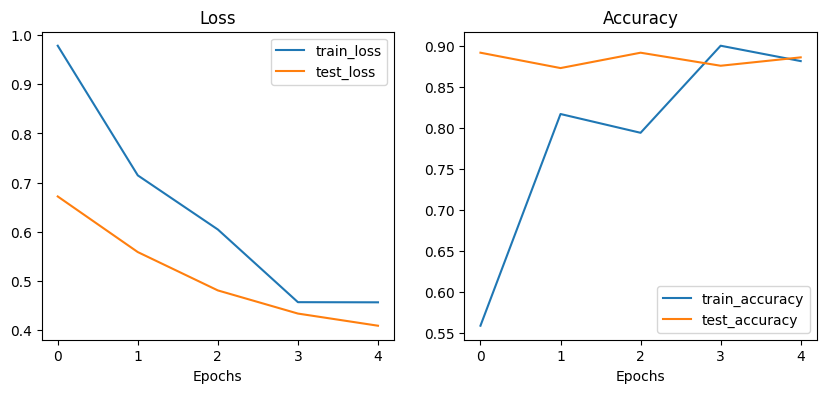

In [20]:
plot_results.plot_loss_curves(results)

What do our loss curvers look like in terms of the ideal loss curve?

See here for mode: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

## 6. Make predictions on images from the test set

Some things to keep in mind when making predictions/inference on test data or custom data.

We have to make sure that our data is:
* Same shape - images need to be same shape as model was trained on
* Same datatype - custom data should be in the same data type
* Same device - data should be on the same device as the model
* Same transform - if you've transformed your train data, ideally you will transform the test data the same

To do all of this automatically, let's create a function called `pred_and_plot_image()` that:

1. Take in:
    * a trained model
    * a list of class names
    * a filepath to a target image
    * an image size
    * a transform
    * a target device
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference (this will turn off things like `nn.Dropout()`)
6. Transform the target image and make sure its dimensionality is suited for the model (this mainly relates to batch size)
7. Make a prediction on the image by passing to the model
8. Convert the model's output logit to prediction probabilities using `torch.softmax()`
9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from testp 8

In [21]:
# 1. Take in a trained model...
def pred_and_plot_image(
        model: torch.nn.Module,
        image_path: str,
        class_names: List[str],
        image_size: Tuple[int, int]=(224, 224),
        transform: torchvision.transforms=None,
        device: str="cpu"):
    # 2. Open the mage with PIL
    img = Image.open(image_path)

    # 3. Create a transform if one doesn't exist
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(size=image_size),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
                )
            ])

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on inference mode and eval mode
    model.eval()
    with torch.inference_mode():
        # 6. Transform the image and add an extra batch dimension
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # 7. Make a prediction on the transformed image by passing it to the mode (also ensure it's on the target device)
        target_image_pred = model(transformed_image.to(device))

    # 8. Convert the model's output logits to pred probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert the model's pred probs to pred labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);


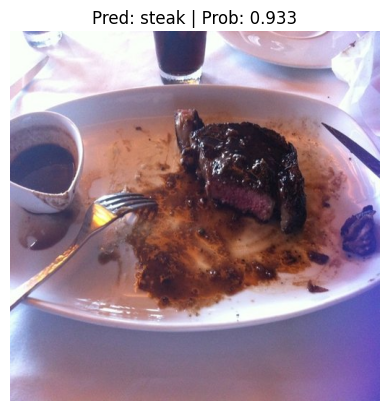

In [22]:
# Get a random list of image paths from the test set
num_image_to_plot = 1
test_image_path_list = list((image_path / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(
    population=test_image_path_list,
    k=num_image_to_plot)

# Make predictions on and plot the images
for img_path in test_image_path_sample:
    pred_and_plot_image(
        model=model,
        image_path=img_path,
        class_names=class_name_list,
        image_size=(224, 224))

### 6.1. Making predictions on a custom image

In [24]:

# Get a custom image
custom_image = "pizza-test.jpg"

with open(custom_image, "wb") as f:
    req = requests.get("https://pixabay.com/get/g42c2e02a2cb5f534ecae59d725cac672f2f451423e0967dc9395415e6c5bd3fbabe81d7f01b60da8698ca3d76f189ddf1008646f5628cf3c51e460cad5f12706_1280.jpg")
    f.write(req.content)

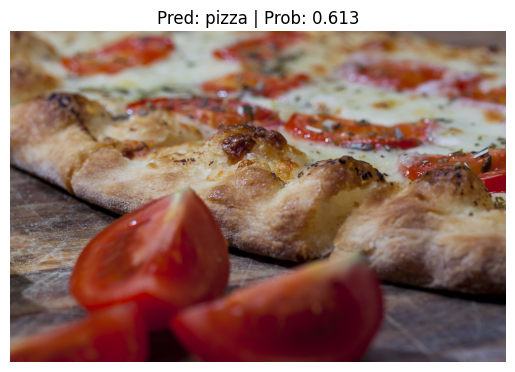

In [29]:
pred_and_plot_image(
    model=model,
    image_path="pizza-test.jpg",
    class_names=class_name_list,
    image_size=(224, 224))